<a href="https://colab.research.google.com/github/sarahjywu/Permafrost/blob/main/PermafrostConditions%26ALTPred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ALT rows with missing coordinates:
Empty DataFrame
Columns: [year, lat, lon, ALT, ds]
Index: []
Condition rows with missing coordinates:
Empty DataFrame
Columns: [Name, Year, Snow depth, air temperature [°C], Ground temperature at 100cm [°C], Ground temperature at 25cm [°C], Ground temperature at  50cm [°C], Ground temperature at 75cm [°C], Ground surface temperature [°C], Latitude, Longitude, ds]
Index: []


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_dn3b48h/tj7qezqh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_dn3b48h/85nn16wl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75646', 'data', 'file=/tmp/tmp_dn3b48h/tj7qezqh.json', 'init=/tmp/tmp_dn3b48h/85nn16wl.json', 'output', 'file=/tmp/tmp_dn3b48h/prophet_model7tvlhmc3/prophet_model-20250714213258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:32:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:33:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/

Feature impact on ALT prediction (learned coefficients):
air temperature [°C]: -0.0127
Ground temperature at 25cm [°C]: -0.0124
Ground temperature at 75cm [°C]: -0.0119
Ground temperature at 100cm [°C]: -0.0100
Ground temperature at  50cm [°C]: -0.0075
Ground surface temperature [°C]: -0.0050
Snow depth: -0.0025


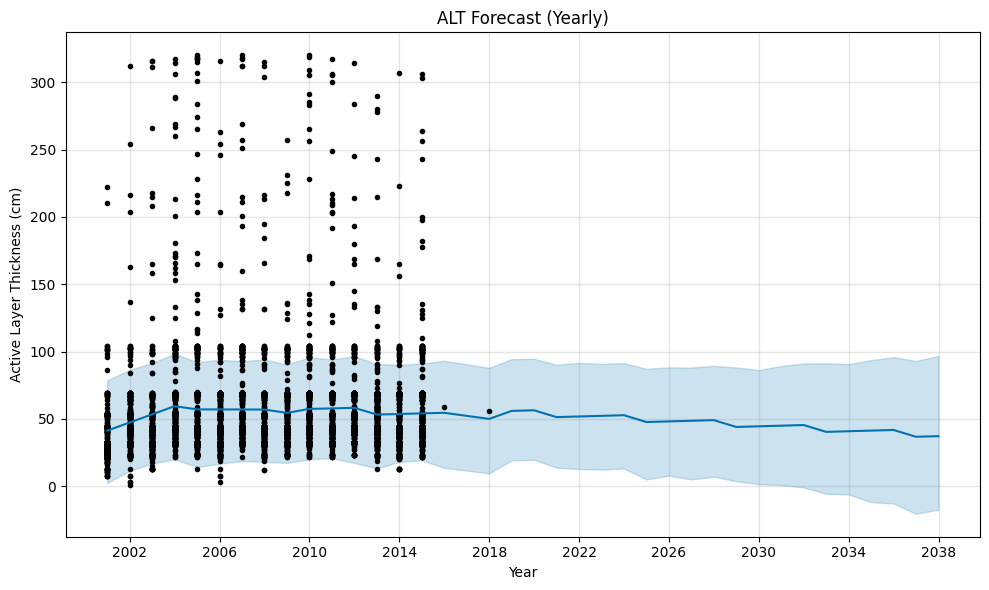

In [1]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import numpy as np
import seaborn as sns
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_components


# Load condition and ALT datasets
df = pd.read_csv("/content/conditions.csv")
dfALT1 = pd.read_csv("/content/Cleaned_Cluster_1_ALT (1).csv")
dfALT2 = pd.read_csv("/content/ALT_Data_in_Centimeters (2).csv")

dfALT1 = dfALT1[["year", "lat", "lon", "ALT"]].copy()
dfALT2 = dfALT2[["year", "lat", "lon", "ALT"]].copy()

# Convert years to datetime
dfALT1["ds"] = pd.to_datetime(dfALT1["year"].astype(str), format="%Y")
dfALT2["ds"] = pd.to_datetime(dfALT2["year"].astype(str), format="%Y")
df["ds"] = pd.to_datetime(df["Year"].astype(str), format="%Y")

# Combine ALT datasets
dfALT = pd.concat([dfALT1, dfALT2], ignore_index=True)

# Drop rows with missing coordinates
print("ALT rows with missing coordinates:")
print(dfALT[dfALT[['lat', 'lon']].isnull().any(axis=1)])
print("Condition rows with missing coordinates:")
print(df[df[['Latitude', 'Longitude']].isnull().any(axis=1)])

dfALT = dfALT.dropna(subset=['lat', 'lon'])
df = df.dropna(subset=['Latitude', 'Longitude'])

# Feature variables from condition dataset
feature_vars = [
    "Snow depth",
    "air temperature [°C]",
    "Ground surface temperature [°C]",
    "Ground temperature at 25cm [°C]",
    "Ground temperature at  50cm [°C]",
    "Ground temperature at 75cm [°C]",
    "Ground temperature at 100cm [°C]"
]

#  weights based on distances
weights_matrix = []
for _, alt_row in dfALT.iterrows():
    alt_coords = (alt_row['lat'], alt_row['lon'])
    distances = []
    for _, cond_row in df.iterrows():
        cond_coords = (cond_row['Latitude'], cond_row['Longitude'])
        dist = geodesic(alt_coords, cond_coords).km
        distances.append(1 / (dist ** 2 + 1e-6))  # Avoid divide by zero
    weights = np.array(distances) / sum(distances)
    weights_matrix.append(weights)

# Calculate weighted features
weighted_feature_data = []
for alt_idx, alt_row in dfALT.iterrows():
    weights = weights_matrix[alt_idx]
    weighted_features = {}
    for feature in feature_vars:
        weighted_features[feature] = np.average(df[feature], weights=weights)
    weighted_features['ds'] = alt_row['ds']
    weighted_features['lat'] = alt_row['lat']
    weighted_features['lon'] = alt_row['lon']
    weighted_features['ALT'] = alt_row['ALT']
    weighted_feature_data.append(weighted_features)

# Prepare final DataFrame for Prophet
df_weighted_final = pd.DataFrame(weighted_feature_data)
df_weighted_final.rename(columns={"ALT": "y"}, inplace=True)

# Fit Prophet model
model = Prophet()
for feature in feature_vars:
    model.add_regressor(feature)

model.fit(df_weighted_final)

# Forecast future ALT
future = model.make_future_dataframe(periods=20, freq='Y')
latest_features = df_weighted_final[feature_vars].iloc[-1]
for feature in feature_vars:
    future[feature] = latest_features[feature]

forecast = model.predict(future)

# evaulating weights of each feature
modelparams = model.params
feature_effects = {}
for idx, feature in enumerate(feature_vars):
    beta_mean = modelparams['beta'][0][idx]
    feature_effects[feature] = beta_mean

# Print feature importance
print("Feature impact on ALT prediction (learned coefficients):")
for feature, weight in sorted(feature_effects.items(), key=lambda x: abs(x[1]), reverse=True):
    print(f"{feature}: {weight:.4f}")

# Plot forecast
fig = model.plot(forecast)
plt.title("ALT Forecast (Yearly)")
plt.xlabel("Year")
plt.ylabel("Active Layer Thickness (cm)")
plt.tight_layout()
plt.show()
